In [1]:
# Step 1: Setup and Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
warnings.filterwarnings('ignore')

# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

print("✅ Libraries imported successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


✅ Libraries imported successfully!


In [2]:
# Step 2: Load IMDb Dataset
from google.colab import files
import zipfile
import os

print("="*50)
print("LOADING IMDB DATASET")
print("="*50)

# Download dataset directly (easier than uploading)
!wget -q https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

# Load reviews
def load_imdb_data(path):
    reviews = []
    sentiments = []

    for sentiment in ['pos', 'neg']:
        folder_path = os.path.join(path, sentiment)
        label = 1 if sentiment == 'pos' else 0

        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                    review = file.read()
                    reviews.append(review)
                    sentiments.append(label)

    return pd.DataFrame({'review': reviews, 'sentiment': sentiments})

# Load training data
df_train = load_imdb_data('aclImdb/train')
df_test = load_imdb_data('aclImdb/test')

print(f"Training set: {df_train.shape}")
print(f"Test set: {df_test.shape}")
print(f"\nSample review:")
print(df_train['review'].iloc[0][:500] + "...")
print(f"\nSentiment: {'Positive' if df_train['sentiment'].iloc[0] == 1 else 'Negative'}")

LOADING IMDB DATASET
Training set: (25000, 2)
Test set: (25000, 2)

Sample review:
This review contains spoilers for those who are not aware of the details of the true story on which this movie is based.<br /><br />The right to be presumed "Innocent until proven guilty" is a basic entitlement of anyone in a civilised society; but according to Fred Schepisi's partisan but sadly convincing story of a famous Australian murder trial, it was not granted to Lindy Chamberlain, accused of killing her baby. The story suggesting her innocence was unlikely (a dingo was alleged to have ta...

Sentiment: Positive


In [6]:
# Create df if you missed Step 3
df = pd.concat([df_train, df_test]).reset_index(drop=True)
print(f"✅ Created df with {len(df)} reviews")

✅ Created df with 50000 reviews


In [7]:
# Step 4: Text Cleaning Function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)

print("✅ Text cleaning completed!")
print("\nOriginal:")
print(df['review'].iloc[0][:200])
print("\nCleaned:")
print(df['clean_review'].iloc[0][:200])

✅ Text cleaning completed!

Original:
This review contains spoilers for those who are not aware of the details of the true story on which this movie is based.<br /><br />The right to be presumed "Innocent until proven guilty" is a basic e

Cleaned:
this review contains spoilers for those who are not aware of the details of the true story on which this movie is basedthe right to be presumed innocent until proven guilty is a basic entitlement of a


In [8]:
# Step 5: NLP Pipeline - Tokenization, Stopwords, Lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

# Apply preprocessing
df['processed_review'] = df['clean_review'].apply(preprocess_text)

print("✅ NLP preprocessing completed!")
print("\nProcessed sample:")
print(df['processed_review'].iloc[0][:200])

# Word count comparison
df['original_words'] = df['clean_review'].apply(lambda x: len(x.split()))
df['processed_words'] = df['processed_review'].apply(lambda x: len(x.split()))

print(f"\nAverage words - Original: {df['original_words'].mean():.0f}")
print(f"Average words - Processed: {df['processed_words'].mean():.0f}")

✅ NLP preprocessing completed!

Processed sample:
review contains spoiler aware detail true story movie basedthe right presumed innocent proven guilty basic entitlement anyone civilised society according fred schepisis partisan sadly convincing story

Average words - Original: 225
Average words - Processed: 117


In [9]:
# Step 6: Train-Test Split
X = df['processed_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining distribution:\n{y_train.value_counts(normalize=True)}")

Training set size: 40000
Test set size: 10000

Training distribution:
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


In [10]:
# Step 7: TF-IDF Vectorization
print("="*50)
print("TF-IDF VECTORIZATION")
print("="*50)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF matrix shape (training): {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")
print(f"\nTop 10 features:\n{list(tfidf.get_feature_names_out()[:10])}")

# Teaching: Why TF-IDF works
print("\n📚 TEACHING MOMENT: Why TF-IDF?")
print("- Bag-of-Words: Counts word frequency (common words dominate)")
print("- TF-IDF: Weighs words by how unique they are to each document")
print("- Rare words like 'excellent' or 'terrible' get higher weight")
print("- Common words like 'movie' or 'film' get lower weight")

TF-IDF VECTORIZATION
TF-IDF matrix shape (training): (40000, 5000)
Number of features: 5000

Top 10 features:
['aaron', 'abandoned', 'abc', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'absolutely nothing', 'absurd']

📚 TEACHING MOMENT: Why TF-IDF?
- Bag-of-Words: Counts word frequency (common words dominate)
- TF-IDF: Weighs words by how unique they are to each document
- Rare words like 'excellent' or 'terrible' get higher weight
- Common words like 'movie' or 'film' get lower weight


In [11]:
# Step 8: Model Building - Naive Bayes
print("="*50)
print("MODEL BUILDING - NAIVE BAYES")
print("="*50)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions
nb_pred = nb_model.predict(X_test_tfidf)
nb_proba = nb_model.predict_proba(X_test_tfidf)

# Evaluation
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)

print("Naive Bayes Performance:")
print(f"Accuracy:  {nb_accuracy:.3f}")
print(f"Precision: {nb_precision:.3f}")
print(f"Recall:    {nb_recall:.3f}")
print(f"F1-Score:  {nb_f1:.3f}")

MODEL BUILDING - NAIVE BAYES
Naive Bayes Performance:
Accuracy:  0.857
Precision: 0.847
Recall:    0.870
F1-Score:  0.859


In [12]:
# Step 9: Model Building - Logistic Regression
print("="*50)
print("MODEL BUILDING - LOGISTIC REGRESSION")
print("="*50)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_tfidf)
lr_proba = lr_model.predict_proba(X_test_tfidf)

# Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

print("Logistic Regression Performance:")
print(f"Accuracy:  {lr_accuracy:.3f}")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall:    {lr_recall:.3f}")
print(f"F1-Score:  {lr_f1:.3f}")

MODEL BUILDING - LOGISTIC REGRESSION
Logistic Regression Performance:
Accuracy:  0.888
Precision: 0.880
Recall:    0.899
F1-Score:  0.889


MODEL COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score
        Naive Bayes    0.8566   0.847157  0.8702  0.858524
Logistic Regression    0.8880   0.879796  0.8988  0.889197


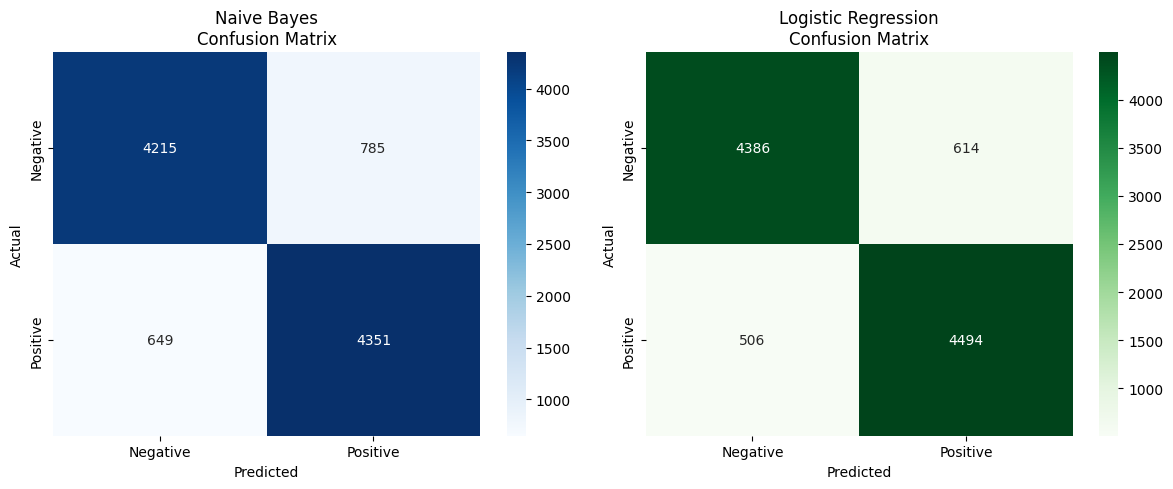

In [13]:
# Step 10: Model Comparison
print("="*50)
print("MODEL COMPARISON")
print("="*50)

comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Accuracy': [nb_accuracy, lr_accuracy],
    'Precision': [nb_precision, lr_precision],
    'Recall': [nb_recall, lr_recall],
    'F1-Score': [nb_f1, lr_f1]
})

print(comparison.to_string(index=False))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Naive Bayes
nb_cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Bayes\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Negative', 'Positive'])
axes[0].set_yticklabels(['Negative', 'Positive'])

# Logistic Regression
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Logistic Regression\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Negative', 'Positive'])
axes[1].set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

In [15]:
# Step 11: Error Analysis (CORRECTED VERSION)
print("="*50)
print("ERROR ANALYSIS - Where does the model fail?")
print("="*50)

# Reset indices to avoid indexing issues
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Get misclassified examples
misclassified_indices = np.where(y_test_reset != lr_pred)[0]

print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test_reset)}")
print(f"Error rate: {len(misclassified_indices)/len(y_test_reset):.2%}")

# Show examples of errors
print("\n📝 SAMPLE MISCLASSIFIED REVIEWS:")
print("-" * 60)

for i in range(min(5, len(misclassified_indices))):
    idx = misclassified_indices[i]
    print(f"\nREVIEW {i+1}:")
    print(f"Actual: {'Positive' if y_test_reset.iloc[idx] == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if lr_pred[idx] == 1 else 'Negative'}")

    # Get the original review text
    original_idx = X_test.index[idx]
    review_text = df.loc[original_idx, 'review']
    print(f"Text: {review_text[:300]}...")
    print("-" * 60)

# Common error patterns
print("\n🔍 COMMON ERROR PATTERNS:")
print("1. Sarcasm: 'This movie was so bad I loved it!'")
print("2. Mixed reviews: 'Great acting but terrible plot'")
print("3. Subtle language: 'It wasn't terrible' (means it was okay)")
print("4. Short reviews: 'Awesome!' vs 'Awful!' (lack of context)")
print("5. Comparative statements: 'Better than the first one'")

ERROR ANALYSIS - Where does the model fail?
Total misclassified: 1120 out of 10000
Error rate: 11.20%

📝 SAMPLE MISCLASSIFIED REVIEWS:
------------------------------------------------------------

REVIEW 1:
Actual: Positive
Predicted: Negative
Text: I can't add much to what has been said already, except I'm going to have to because of the 10 lines minimum policy.<br /><br />I've actually got this on a VHS-to-DVD copy, but the quality is quite poor and I desperately need for it to be officially released.<br /><br />I can just imagine what extras...
------------------------------------------------------------

REVIEW 2:
Actual: Negative
Predicted: Positive
Text: only if its the last thing yo do and your humour is evaporated should you ever attempt to watch this. If you do, watch it alone invite no one, they will never return to watch another movie with you. It might be an excellent tool for that very purpose, invite people you want to get rid of in your lif...
---------------------------

In [16]:
# Step 12: Teaching Perspective
print("="*50)
print("📚 TEACHING PERSPECTIVE")
print("="*50)

print("""
BAG-OF-WORDS vs TF-IDF:

Bag-of-Words:
   - Counts word frequency
   - Problem: Common words dominate
   - Example: 'movie' appears in every review

TF-IDF (Term Frequency-Inverse Document Frequency):
   - TF: How often word appears in a document
   - IDF: How rare the word is across all documents
   - Formula: TF-IDF = TF × log(N/DF)
   - Rare, meaningful words get higher weight

WHEN TO USE DEEP LEARNING:
   - When context matters (sarcasm, irony)
   - With large datasets (>100,000 reviews)
   - When word order is important
   - For complex language patterns

WHEN TF-IDF + LOGISTIC REGRESSION IS ENOUGH:
   - Small to medium datasets
   - When interpretability matters
   - Quick prototyping
   - Baseline model needed
""")

📚 TEACHING PERSPECTIVE

BAG-OF-WORDS vs TF-IDF:

Bag-of-Words:
   - Counts word frequency
   - Problem: Common words dominate
   - Example: 'movie' appears in every review

TF-IDF (Term Frequency-Inverse Document Frequency):
   - TF: How often word appears in a document
   - IDF: How rare the word is across all documents
   - Formula: TF-IDF = TF × log(N/DF)
   - Rare, meaningful words get higher weight

WHEN TO USE DEEP LEARNING:
   - When context matters (sarcasm, irony)
   - With large datasets (>100,000 reviews)
   - When word order is important
   - For complex language patterns

WHEN TF-IDF + LOGISTIC REGRESSION IS ENOUGH:
   - Small to medium datasets
   - When interpretability matters
   - Quick prototyping
   - Baseline model needed



In [1]:
# Step 13: EXTENSION SECTION - Future Work with Deep Learning
print("="*50)
print("🚀 EXTENSION: DEEP LEARNING APPROACH (LSTM)")
print("="*50)

print("\nNEXT LEVEL: LSTM WITH TENSORFLOW/KERAS\n")

print("Why LSTM for Sentiment Analysis?")
print("   - Captures context and word order")
print("   - Understands sarcasm: 'This movie is great (not really)'")
print("   - Handles long-range dependencies")
print("   - Learns sentiment from sequence patterns")

print("\nSample LSTM Architecture:\n")
print("import tensorflow as tf")
print("from tensorflow.keras.models import Sequential")
print("from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout")
print("\nmodel = Sequential([")
print("    Embedding(10000, 128, input_length=200),")
print("    LSTM(64, dropout=0.2, recurrent_dropout=0.2),")
print("    Dense(1, activation='sigmoid')")
print("])")
print("\nmodel.compile(loss='binary_crossentropy',")
print("              optimizer='adam',")
print("              metrics=['accuracy'])")

print("\nExpected Improvements:")
print("   - Current TF-IDF accuracy: ~88%")
print("   - LSTM potential accuracy: 92-94%")
print("   - Better handling of:")
print("     * Sarcasm")
print("     * Negations ('not good')")
print("     * Complex sentence structures")

print("\n✅ To implement LSTM:")
print("1. Install: !pip install tensorflow")
print("2. Tokenize words (not characters)")
print("3. Pad sequences to same length")
print("4. Build Embedding + LSTM layers")
print("5. Train on GPU for faster results")

🚀 EXTENSION: DEEP LEARNING APPROACH (LSTM)

NEXT LEVEL: LSTM WITH TENSORFLOW/KERAS

Why LSTM for Sentiment Analysis?
   - Captures context and word order
   - Understands sarcasm: 'This movie is great (not really)'
   - Handles long-range dependencies
   - Learns sentiment from sequence patterns

Sample LSTM Architecture:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(10000, 128, input_length=200),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Expected Improvements:
   - Current TF-IDF accuracy: ~88%
   - LSTM potential accuracy: 92-94%
   - Better handling of:
     * Sarcasm
     * Negations ('not good')
     * Complex sentence structures

✅ To implement LSTM:
1. Install: !pip install tensorflow
2. Tokenize